# Understanding Demixed PCA (dPCA)

## What is Demixed PCA?

**Standard PCA** finds directions that maximize variance, but these components often mix multiple sources of variability, making interpretation difficult.

**Demixed PCA (dPCA)** separates variance into interpretable components based on known experimental variables (e.g., time, condition, their interaction).

## Key Idea

```
Standard PCA:  X = U × S × V^T
               (Components mix time + condition + interaction)

Demixed PCA:   X = X_time + X_condition + X_interaction + noise
               Each component captures ONE source of variance
```

## Original Paper
Kobak et al., 2016: "Demixed principal component analysis of neural population data"

In [1]:
# Setup
import sys
from pathlib import Path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
print("Setup complete!")

Setup complete!


## 1. Data Structure for dPCA

dPCA requires data organized by experimental conditions:

```
Data shape: [n_features, n_timepoints, n_conditions]

Example (Gait × Mental State):
- n_features = 15 (body factors: hip, knee, ankle, etc.)
- n_timepoints = 100 (gait cycle: 0-100%)
- n_conditions = 5 (mental states: neutral, anxious, relaxed, focused, fatigued)
```

**Important:** Each "condition" (mental state) must be categorical, not continuous.

In [2]:
# Generate synthetic data
np.random.seed(42)

n_features = 15      # Body factors (gait variables)
n_timepoints = 100   # Gait cycle
n_conditions = 5     # Mental states (categorical)

# Labels
feature_labels = [
    'hip_flexion', 'hip_abduction', 'knee_flexion', 'ankle_dorsiflexion',
    'pelvis_tilt', 'pelvis_obliquity', 'trunk_flexion', 'trunk_rotation',
    'stride_length', 'step_width', 'cadence', 'grf_vertical', 
    'grf_anterior', 'grf_lateral', 'com_velocity'
]
condition_labels = ['neutral', 'anxious', 'relaxed', 'focused', 'fatigued']

# Generate data with known structure
t = np.linspace(0, 2*np.pi, n_timepoints)
data = np.zeros((n_features, n_timepoints, n_conditions))

for f in range(n_features):
    for c in range(n_conditions):
        # 1. TIME component: Gait cycle pattern (same for all conditions)
        time_component = np.sin(t + f * 0.3) + 0.5 * np.cos(2*t + f * 0.2)
        
        # 2. CONDITION component: Mental state effect (constant across time)
        condition_effect = 0.5 * (c - 2)  # Different offset for each condition
        if f in [0, 2, 8]:  # Some features more affected by condition
            condition_effect *= 2
        
        # 3. INTERACTION: Condition changes the shape of time pattern
        interaction = 0.3 * np.sin(t + c * 0.5) * (1 if f < 5 else 0.2)
        
        # 4. Noise
        noise = np.random.randn(n_timepoints) * 0.15
        
        data[f, :, c] = time_component + condition_effect + interaction + noise

print(f"Data shape: {data.shape}")
print(f"  n_features: {n_features}")
print(f"  n_timepoints: {n_timepoints}")
print(f"  n_conditions: {n_conditions} ({', '.join(condition_labels)})")

Data shape: (15, 100, 5)
  n_features: 15
  n_timepoints: 100
  n_conditions: 5 (neutral, anxious, relaxed, focused, fatigued)


## 2. Visualize Raw Data

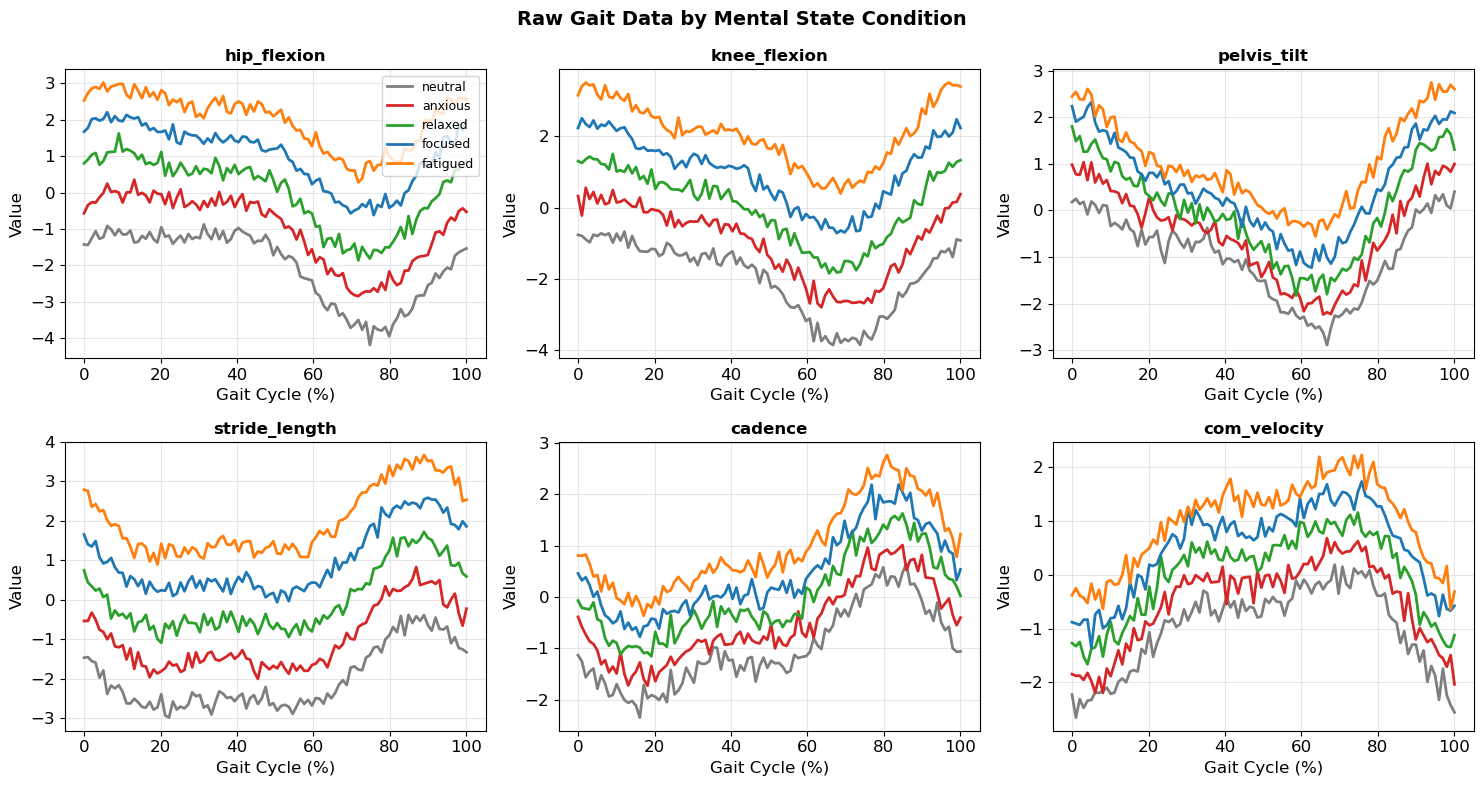

Observation:
  - All conditions share similar TIME pattern (gait cycle)
  - Different conditions have different offsets (CONDITION effect)
  - Some conditions have slightly different shapes (INTERACTION)


In [3]:
# Visualize raw data: same feature across conditions
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
colors = ['#7f7f7f', '#d62728', '#2ca02c', '#1f77b4', '#ff7f0e']
time_axis = np.linspace(0, 100, n_timepoints)

for ax, f_idx in zip(axes.flat[:6], [0, 2, 4, 8, 10, 14]):
    for c_idx, (state, color) in enumerate(zip(condition_labels, colors)):
        ax.plot(time_axis, data[f_idx, :, c_idx], label=state, color=color, lw=2)
    ax.set_title(feature_labels[f_idx], fontsize=12, fontweight='bold')
    ax.set_xlabel('Gait Cycle (%)')
    ax.set_ylabel('Value')
    ax.grid(True, alpha=0.3)

axes[0, 0].legend(loc='upper right', fontsize=9)
plt.suptitle('Raw Gait Data by Mental State Condition', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Observation:")
print("  - All conditions share similar TIME pattern (gait cycle)")
print("  - Different conditions have different offsets (CONDITION effect)")
print("  - Some conditions have slightly different shapes (INTERACTION)")

## 3. Theory: Marginalization

dPCA decomposes data into **marginalizations** (sources of variance):

### Time Marginalization
Average across conditions → What changes over time (gait cycle)?
```
X_time[f, t] = mean_over_conditions(X[f, t, :])
```

### Condition Marginalization  
Average across time → What differs between mental states?
```
X_condition[f, c] = mean_over_time(X[f, :, c])
```

### Interaction Marginalization
Residual after removing time and condition effects
```
X_interaction = X - X_time - X_condition + grand_mean
```

In [4]:
# Compute marginalizations manually
grand_mean = data.mean()

# Time marginalization: average across conditions
X_time = data.mean(axis=2, keepdims=True)  # [n_features, n_timepoints, 1]
X_time = np.broadcast_to(X_time, data.shape)

# Condition marginalization: average across time
X_condition = data.mean(axis=1, keepdims=True)  # [n_features, 1, n_conditions]
X_condition = np.broadcast_to(X_condition, data.shape)

# Interaction: residual
X_interaction = data - X_time - X_condition + grand_mean

# Calculate variance explained by each marginalization
var_total = np.var(data)
var_time = np.var(X_time - grand_mean)
var_condition = np.var(X_condition - grand_mean)
var_interaction = np.var(X_interaction)

print("=== Variance Decomposition ===")
print(f"Total variance: {var_total:.4f}")
print(f"")
print(f"Time:        {var_time:.4f} ({var_time/var_total*100:.1f}%)")
print(f"Condition:   {var_condition:.4f} ({var_condition/var_total*100:.1f}%)")
print(f"Interaction: {var_interaction:.4f} ({var_interaction/var_total*100:.1f}%)")

=== Variance Decomposition ===
Total variance: 1.5302

Time:        0.7032 (46.0%)
Condition:   0.8022 (52.4%)
Interaction: 0.0252 (1.6%)


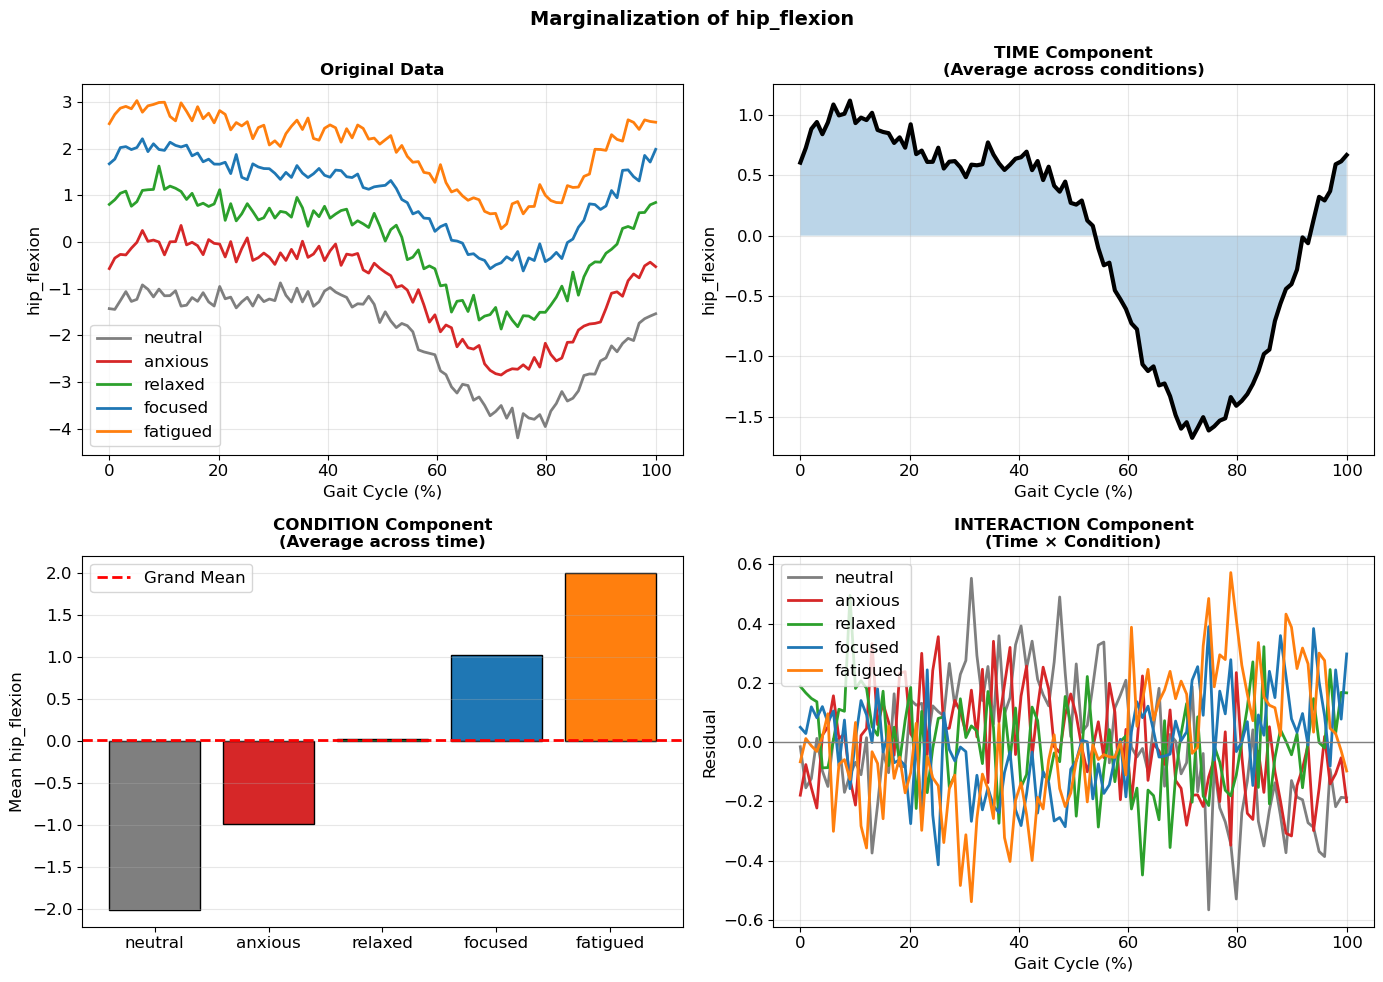

In [5]:
# Visualize marginalizations for one feature
feature_idx = 0  # hip_flexion

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Original data
ax1 = axes[0, 0]
for c_idx, (state, color) in enumerate(zip(condition_labels, colors)):
    ax1.plot(time_axis, data[feature_idx, :, c_idx], label=state, color=color, lw=2)
ax1.set_title('Original Data', fontsize=12, fontweight='bold')
ax1.set_xlabel('Gait Cycle (%)')
ax1.set_ylabel(feature_labels[feature_idx])
ax1.legend()
ax1.grid(True, alpha=0.3)

# Time marginalization
ax2 = axes[0, 1]
ax2.plot(time_axis, X_time[feature_idx, :, 0], 'k-', lw=3)
ax2.fill_between(time_axis, X_time[feature_idx, :, 0], alpha=0.3)
ax2.set_title('TIME Component\n(Average across conditions)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Gait Cycle (%)')
ax2.set_ylabel(feature_labels[feature_idx])
ax2.grid(True, alpha=0.3)

# Condition marginalization
ax3 = axes[1, 0]
condition_means = X_condition[feature_idx, 0, :]
bars = ax3.bar(condition_labels, condition_means, color=colors, edgecolor='black')
ax3.axhline(y=grand_mean, color='red', linestyle='--', lw=2, label='Grand Mean')
ax3.set_title('CONDITION Component\n(Average across time)', fontsize=12, fontweight='bold')
ax3.set_ylabel(f'Mean {feature_labels[feature_idx]}')
ax3.legend()
ax3.grid(True, axis='y', alpha=0.3)

# Interaction
ax4 = axes[1, 1]
for c_idx, (state, color) in enumerate(zip(condition_labels, colors)):
    ax4.plot(time_axis, X_interaction[feature_idx, :, c_idx], label=state, color=color, lw=2)
ax4.axhline(y=0, color='gray', linestyle='-', lw=1)
ax4.set_title('INTERACTION Component\n(Time × Condition)', fontsize=12, fontweight='bold')
ax4.set_xlabel('Gait Cycle (%)')
ax4.set_ylabel('Residual')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.suptitle(f'Marginalization of {feature_labels[feature_idx]}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 4. dPCA Algorithm

### Step 1: Compute Marginalized Covariance Matrices

For each marginalization φ (time, condition, interaction):

$$C_φ = \frac{1}{n} X_φ X_φ^T$$

### Step 2: Find Demixing Axes

Find encoder D and decoder F that:
- Maximize variance of each marginalization
- Minimize reconstruction error

$$\min_D \sum_φ ||X_φ - F_φ D X||^2$$

### Step 3: Project Data

```python
# Encode: project to latent space
Z = D @ X_flat  # [n_components, n_timepoints * n_conditions]

# For each marginalization:
Z_time = D_time @ X_flat      # Captures time variance
Z_condition = D_cond @ X_flat  # Captures condition variance
```

### Key Insight
Each component is **interpretable**: we know whether it captures time, condition, or their interaction!

## 5. Apply dPCA to Gait Data

In [6]:
# Import and fit DemixedPCA
from src.dpca import DemixedPCA

# Fit dPCA
dpca = DemixedPCA(n_components=5, regularizer='auto')
dpca.fit(
    data,  # [n_features, n_timepoints, n_conditions]
    feature_labels=feature_labels,
    marginalization_labels=['time', 'condition', 'interaction']
)

print("=== dPCA Fitting Complete ===")
print(f"Components per marginalization: {dpca.n_components}")
print(f"Regularization: {dpca._regularizer_value:.2e}")

=== dPCA Fitting Complete ===
Components per marginalization: 5
Regularization: 1.00e-10


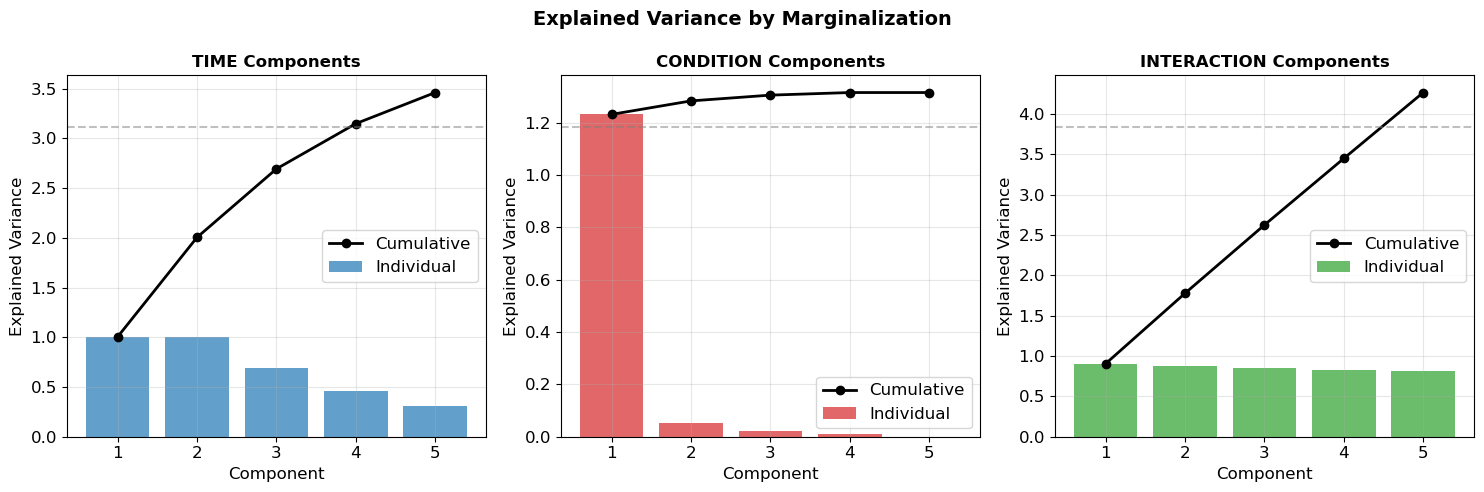

In [7]:
# Visualize explained variance
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

marg_names = ['time', 'condition', 'interaction']
marg_colors = ['#1f77b4', '#d62728', '#2ca02c']

for ax, marg, color in zip(axes, marg_names, marg_colors):
    exp_var = dpca.explained_variance_[marg]
    cumsum = np.cumsum(exp_var)
    
    ax.bar(range(1, len(exp_var)+1), exp_var, color=color, alpha=0.7, label='Individual')
    ax.plot(range(1, len(exp_var)+1), cumsum, 'ko-', lw=2, label='Cumulative')
    ax.axhline(y=0.9*cumsum[-1], color='gray', linestyle='--', alpha=0.5)
    
    ax.set_xlabel('Component')
    ax.set_ylabel('Explained Variance')
    ax.set_title(f'{marg.upper()} Components', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Explained Variance by Marginalization', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 6. Interpret Components

### Condition Components: Mental State Separation

The condition components capture what differs between mental states.

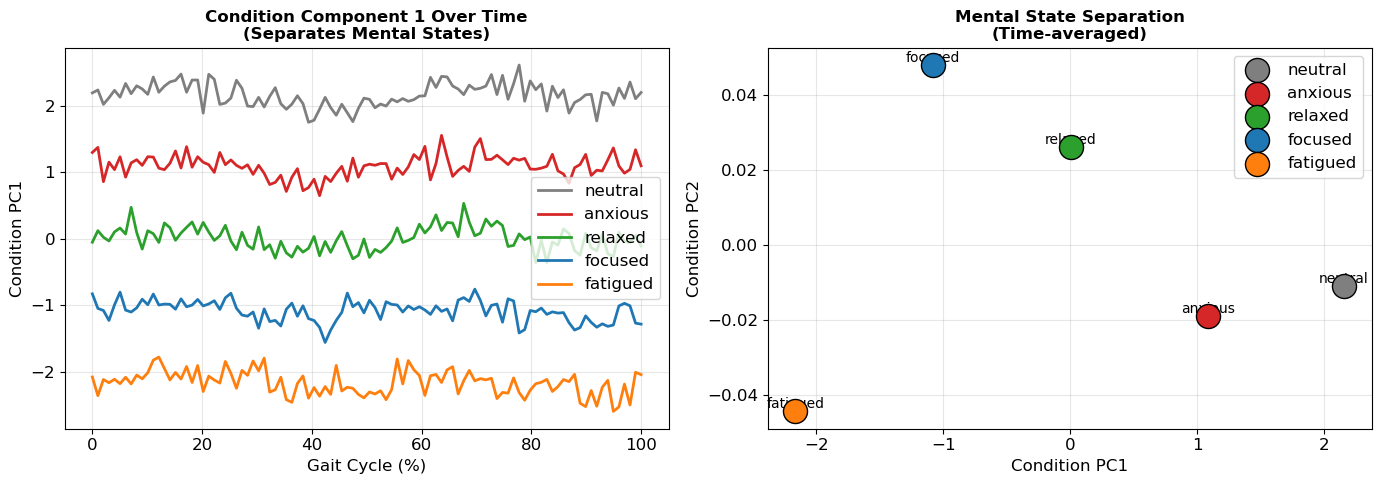

Interpretation:
  - Condition PC1 separates mental states
  - Different states cluster in different regions of latent space


In [8]:
# Project data onto condition components
Z_condition = dpca.transform(data, marginalization='condition')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Component time courses by condition
ax1 = axes[0]
for c_idx, (state, color) in enumerate(zip(condition_labels, colors)):
    ax1.plot(time_axis, Z_condition[0, :, c_idx], label=state, color=color, lw=2)
ax1.set_xlabel('Gait Cycle (%)')
ax1.set_ylabel('Condition PC1')
ax1.set_title('Condition Component 1 Over Time\n(Separates Mental States)', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2D scatter: PC1 vs PC2 of condition
ax2 = axes[1]
for c_idx, (state, color) in enumerate(zip(condition_labels, colors)):
    mean_pc1 = Z_condition[0, :, c_idx].mean()
    mean_pc2 = Z_condition[1, :, c_idx].mean()
    ax2.scatter(mean_pc1, mean_pc2, c=color, s=300, label=state, edgecolors='black', zorder=5)
    ax2.annotate(state, (mean_pc1, mean_pc2), fontsize=10, ha='center', va='bottom')
ax2.set_xlabel('Condition PC1')
ax2.set_ylabel('Condition PC2')
ax2.set_title('Mental State Separation\n(Time-averaged)', fontsize=12, fontweight='bold')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Interpretation:")
print("  - Condition PC1 separates mental states")
print("  - Different states cluster in different regions of latent space")

### Time Components: Gait Cycle Patterns

The time components capture what changes over the gait cycle (shared across all conditions).

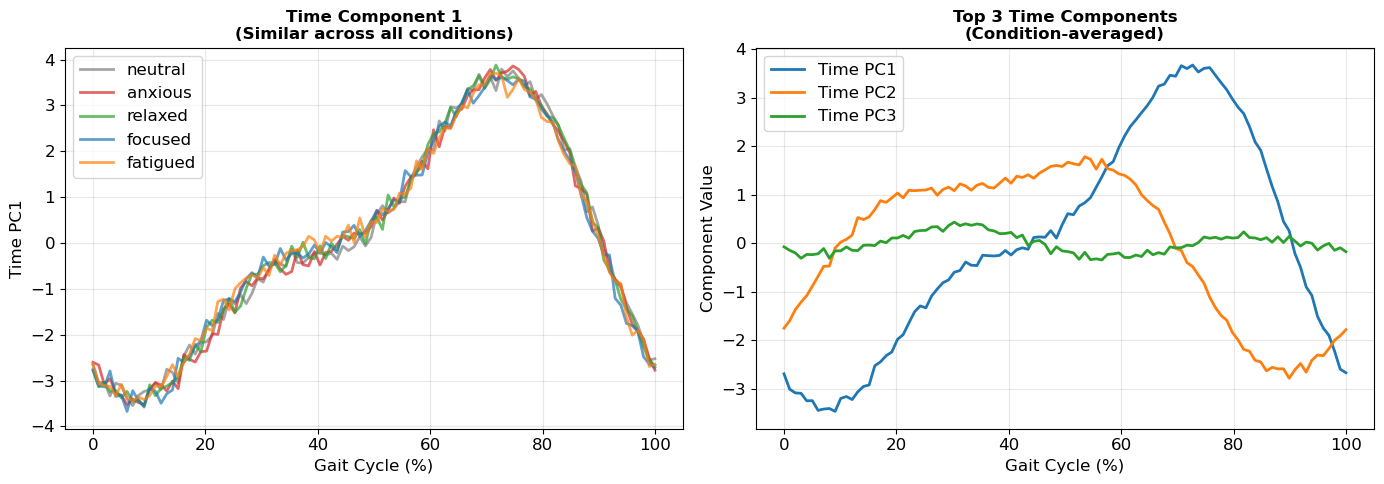

Interpretation:
  - Time components capture gait cycle patterns
  - All conditions show similar time evolution (as expected)


In [9]:
# Project data onto time components
Z_time = dpca.transform(data, marginalization='time')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Time PC1 across conditions (should overlap)
ax1 = axes[0]
for c_idx, (state, color) in enumerate(zip(condition_labels, colors)):
    ax1.plot(time_axis, Z_time[0, :, c_idx], label=state, color=color, lw=2, alpha=0.7)
ax1.set_xlabel('Gait Cycle (%)')
ax1.set_ylabel('Time PC1')
ax1.set_title('Time Component 1\n(Similar across all conditions)', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Multiple time components
ax2 = axes[1]
for pc in range(3):
    # Average across conditions
    mean_trajectory = Z_time[pc, :, :].mean(axis=1)
    ax2.plot(time_axis, mean_trajectory, lw=2, label=f'Time PC{pc+1}')
ax2.set_xlabel('Gait Cycle (%)')
ax2.set_ylabel('Component Value')
ax2.set_title('Top 3 Time Components\n(Condition-averaged)', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Interpretation:")
print("  - Time components capture gait cycle patterns")
print("  - All conditions show similar time evolution (as expected)")

### Component Weights: Which Features Contribute?

In [ ]:
# Visualize feature weights for condition PC1
fig, ax = plt.subplots(figsize=(10, 6))

# Get encoder weights for condition marginalization
# Note: _encoder is a private attribute storing the encoder matrices
encoder = dpca._encoder['condition']
weights = encoder[0, :]  # First component

# Sort by absolute value
sorted_idx = np.argsort(np.abs(weights))[::-1]
sorted_weights = weights[sorted_idx]
sorted_labels = [feature_labels[i] for i in sorted_idx]

bar_colors = ['#2ca02c' if w > 0 else '#d62728' for w in sorted_weights]
bars = ax.barh(range(len(weights)), sorted_weights, color=bar_colors, alpha=0.8, edgecolor='black')
ax.set_yticks(range(len(weights)))
ax.set_yticklabels(sorted_labels)
ax.set_xlabel('Weight')
ax.set_title('Feature Contributions to Condition PC1\n(Which features separate mental states?)', fontsize=12, fontweight='bold')
ax.axvline(x=0, color='gray', lw=1)
ax.grid(True, axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("Top features for mental state separation:")
for i in range(5):
    direction = "+" if sorted_weights[i] > 0 else "-"
    print(f"  {i+1}. {sorted_labels[i]:20s} ({direction}{abs(sorted_weights[i]):.3f})")

AttributeError: 'DemixedPCA' object has no attribute 'encoders_'

## 7. Summary

### dPCA vs Standard PCA

| Aspect | Standard PCA | Demixed PCA |
|--------|--------------|-------------|
| Goal | Maximize variance | Maximize variance per source |
| Components | Mixed (time + condition + ...) | Separated by source |
| Interpretation | Difficult | Clear: "this component = time" |
| Requirements | Just data matrix | Data + experimental structure |

### When to Use dPCA

✅ **Good for:**
- Data with known experimental structure (conditions/time)
- When you need interpretable components
- Separating "what" (condition) from "when" (time)

❌ **Not suitable for:**
- Continuous scores (use CCA/PLS instead)
- Unknown experimental structure
- When you just want dimensionality reduction

### Data Shape for dPCA

```python
data.shape = [n_features, n_timepoints, n_conditions]

# Example: Gait × Mental State
# n_features = 15 (body factors)
# n_timepoints = 100 (gait cycle)
# n_conditions = 5 (neutral, anxious, relaxed, focused, fatigued)
```

### Key Takeaways

1. **dPCA separates variance sources** - Time, Condition, Interaction
2. **Components are interpretable** - Each captures one source
3. **Condition components separate mental states** - Use for classification
4. **Time components capture gait patterns** - Shared across states

## 8. Comparison: Standard PCA vs dPCA

In [ ]:
# Compare Standard PCA vs dPCA
from sklearn.decomposition import PCA

# Flatten data for standard PCA
data_flat = data.reshape(n_features, -1).T  # [n_timepoints*n_conditions, n_features]

# Fit standard PCA
pca = PCA(n_components=5)
Z_pca = pca.fit_transform(data_flat)
Z_pca = Z_pca.reshape(n_timepoints, n_conditions, -1)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Standard PCA: PC1 by condition
ax1 = axes[0, 0]
for c_idx, (state, color) in enumerate(zip(condition_labels, colors)):
    ax1.plot(time_axis, Z_pca[:, c_idx, 0], label=state, color=color, lw=2)
ax1.set_xlabel('Gait Cycle (%)')
ax1.set_ylabel('PC1')
ax1.set_title('Standard PCA: PC1\n(Mixes time + condition)', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Standard PCA: PC2 by condition
ax2 = axes[0, 1]
for c_idx, (state, color) in enumerate(zip(condition_labels, colors)):
    ax2.plot(time_axis, Z_pca[:, c_idx, 1], label=state, color=color, lw=2)
ax2.set_xlabel('Gait Cycle (%)')
ax2.set_ylabel('PC2')
ax2.set_title('Standard PCA: PC2\n(Also mixes sources)', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# dPCA: Time PC1
ax3 = axes[1, 0]
for c_idx, (state, color) in enumerate(zip(condition_labels, colors)):
    ax3.plot(time_axis, Z_time[0, :, c_idx], label=state, color=color, lw=2, alpha=0.7)
ax3.set_xlabel('Gait Cycle (%)')
ax3.set_ylabel('Time PC1')
ax3.set_title('dPCA: Time PC1\n(Pure time variation)', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# dPCA: Condition PC1
ax4 = axes[1, 1]
for c_idx, (state, color) in enumerate(zip(condition_labels, colors)):
    ax4.plot(time_axis, Z_condition[0, :, c_idx], label=state, color=color, lw=2)
ax4.set_xlabel('Gait Cycle (%)')
ax4.set_ylabel('Condition PC1')
ax4.set_title('dPCA: Condition PC1\n(Pure condition variation)', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.suptitle('Standard PCA vs Demixed PCA', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Key difference:")
print("  Standard PCA: Components mix time and condition effects")
print("  Demixed PCA:  Components are separated by source (time OR condition)")